In [3]:
# Project: Protein stability prediction

In the project you will try to predict protein stability changes upon point mutations. 
We will use acuumulated data from experimental databases, i.e. the Megascale dataset. A current [pre-print paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10402116/) has already preprocessed the dataset and created homology reduced data splits. We will reuse these. To do so, download the data folder from [here](https://polybox.ethz.ch/index.php/s/txvcb5jKy1A0TbY) and unzip it.  

The data includes measurements of changes in the Gibbs free enrgy ($\Delta \Delta G $). 
This will be the value that you will have to predict for a given protein with a point mutation. 
As input data you can use the protein sequence or a protein embedding retreived from ESM, a state of the art protein model.  

Here we will use the sequence as input. 
The model will predict the $\Delta \Delta G $ of point mutations in this sequence. To make training more efficient, the model should directly predict the values for all possible mutations at each position in the sequence. So the expected output is a sequence of $ L \ (sequence \ length) \ x \ 20 \ (number \ amino \ acids)$. This will be shown in detail later.

Below we provide you with a strcuture for the project that you can start with.  
Edit the cells to your liking and add more code to create your final model.


https://www.nature.com/articles/s41598-020-71450-8#Sec12

SyntaxError: invalid syntax (378543715.py, line 3)

In [1]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

In [2]:
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

# function to one hot encode sequence
def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    if sequence != "0":
        for i, aa in enumerate(sequence):
            # set the column corresponding to the amino acid to 1
            one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot
    


# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML"):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        
        self.min_size = 72
        
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values
        # precompute one-hot encoding for faster training
        self.encoded_seqs = {}
        for wt_name in self.wt_names:
            # get the correct row
            mut_row = self.df.loc[wt_name]
            seq = mut_row["wt_seq"][0]
            self.encoded_seqs[wt_name] = one_hot_encode(seq)
            for i in range(self.min_size-len(self.encoded_seqs[wt_name])):
                #print(wt_name, i)
                self.encoded_seqs[wt_name] = torch.cat((self.encoded_seqs[wt_name], one_hot_encode("0")),0)
                

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence in one hot encoding
        sequence_encoding = self.encoded_seqs[wt_name]

        # create mask and target tensors
        mask = torch.zeros((1, len(sequence_encoding),20)) # will be 1 where we have a measurement
        target = torch.zeros((1, len(sequence_encoding),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(sequence_encoding)):
            mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
            target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
     
        
        
        return {"sequence": sequence_encoding[None,:,:].float(), "mask": mask, "labels": target}

In [3]:
#go one directory up
def goOneUp():
    path_parent = os.path.dirname(os.getcwd())

    os.chdir(path_parent)
    os.getcwd()
#goOneUp()
!ls

convolutionWithFixedSize.ipynb	lab4		   LSTMonSeq.ipynb  README.md
lab1				LICENSE		   __MACOSX	    SETUP.md
lab2				lightning_logs	   project
lab3				LinearModel.ipynb  project_data


In [4]:
os.chdir("bc_deep_learning_in_biology")

FileNotFoundError: [Errno 2] No such file or directory: 'bc_deep_learning_in_biology'

In [5]:
os.getcwd()

'/home/course/bc_deep_learning_in_biology'

In [6]:
# usage
dataset_train = SequenceData('project_data/mega_train.csv')
dataset_val= SequenceData('project_data/mega_val.csv')
dataset_test = SequenceData('project_data/mega_test.csv')

# use batch_size=1 bc we treat each sequence as one batch
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [7]:
dataset_train.__getitem__(30)["sequence"][0][30]
dataset_val

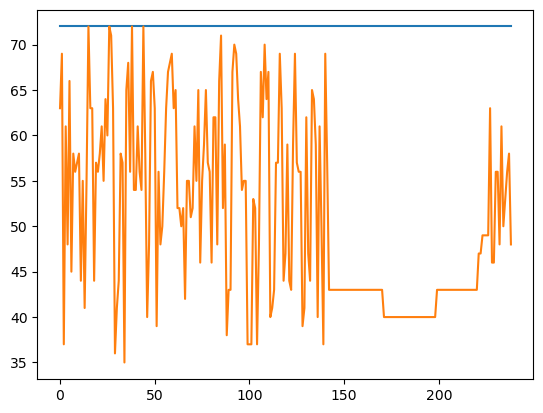

In [8]:

plt.plot([len(dataset_train.encoded_seqs[seq]) for seq in dataset_train.encoded_seqs.keys()])
#max([len(dataset_train.encoded_seqs['1A32.pdb']) for seq in range(len(dataset_train.encoded_seqs))])
    
plt.plot([len(dataset_train.df["aa_seq"][seq][0]) for seq in range(len(dataset_train.df))])
#max([len(dataset_train.df["aa_seq"][seq][0]) for seq in range(len(dataset_train.df))])
    

In [124]:
dataset_train.__getitem__(30)["labels"][0][30][1] #getitem goes through proteins, then through the sequence, then it goes through the 20 aa,
dataset_train.__getitem__(0)["sequence"][0][30]
dataset_train.__getitem__(0)["mask"][0][30]

torch.Size([1, 72, 20])

In [12]:
#Model architecture and training¶

In [9]:
def get_conv2d_out_shape(tensor_shape, conv, pool=2):
    # return the new shape of the tensor after a convolution and pooling
    # tensor_shape: (channels, height, width)
    # convolution arguments
    kernel_size = conv.kernel_size
    stride=conv.stride # 2D array
    padding=conv.padding # 2D array
    dilation=conv.dilation # 2D array
    out_channels = conv.out_channels

    height_out = np.floor((tensor_shape[1]+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    width_out = np.floor((tensor_shape[2]+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        # adjust dimensions to pooling
        height_out/=pool
        width_out/=pool
        
    return int(out_channels),int(height_out),int(width_out)

In [14]:
class MRIModel(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(MRIModel, self).__init__() #initialize parent pytorch module
        self.dropout = nn.Dropout(0.4)
        # read parameters
        shape_in = params["shape_in"]
        #channels_out = params["initial_depth"] 
        #fc1_size = params["fc1_size"]
        
        #### Convolution Layers

        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        ##conv layer 1
        # convolution with kernel size 8, goes from three channels to 
        # number defined by initial_depth in params
        self.conv1 = nn.Conv2d(1, 15, kernel_size = 15, padding = 7) #1; 15; 15; 7 -> train_loss: 0.80; val_loss: 0.66, RMSE: 0.847; change depth to 30, epoch 100 -> tr: 0.66; val: 0.63, rmse: 0.85
                                                                    #same with 30 depth, 100 epochs, but added pooling (with upscaling)-> tr_l: 0.707; v_l: 0.997; rmse: 1.02 - same with 150 epochs 
        ############### TODO ################ 1, 72, 20 -> 
        # get current shape after conv1, use helper function get_conv2d_out_shape, use pool=2
        current_data_shape = get_conv2d_out_shape((30, 72, 20), self.conv1, pool=2)
        #print(current_data_shape)
        ##conv layer 2
        # convolution with kernel size 4, double the amount of channels
        self.conv2 = nn.Conv2d(15, 1, kernel_size = 31, padding = 15) #15; 1; 31; 15 -> train_loss: 0.80; val_loss: 0.66, RMSE: 0.847
        #remember vorher 30, 1, 31, 15 gsi
        # get current shape after conv2, use pool=2 again
        ##current_data_shape = get_conv2d_out_shape(current_data_shape, self.conv2, pool=0)

        #### Fully connected layers
        # compute the flattened size as input for fully connected layer
        ##flat_size = current_data_shape[0] * current_data_shape[1] * current_data_shape[2]
        
        # linear layer reduces data from flat_size to fc1_size
        ##self.fc1 = nn.Linear(flat_size,fc1_size)
        # last linear layer reduces data to output size 1
        ##self.fc2 = nn.Linear(fc1_size, 1)
        
        #####################################
        

    def forward(self,X):
        # our network's forward pass
        
        # Convolution & Pool Layers
        ############# TODO ###############
        # convolution (conv1), then relu, then max pool 
        X = F.sigmoid(self.conv1(X)) #leaky_relu 1.119, tanh 1.5926 (only positive values), sigmoid 1.2797 (only positive values?) RMSE
        X = self.dropout(X)
        X = self.pool(X)
        X = F.interpolate(X, 20)
        X.to(device = "cuda")
        
        X = X.permute(0, 2, 1)
        X.to(device = "cuda")
        X = F.interpolate(X, 72)
        X.to(device = "cuda")
        X = X.permute(0, 2, 1)
        X.to(device = "cuda")
        # convolution (conv2), then relu, then max pool (best model until now 2 layers conv, dropout 0.4, 1, 15, 7; 15. 
        X = self.conv2(X)
        ##X = torch.flatten(X, 1) # flatten all dimensions except batch

        # fully connected layer and ReLU
        ##X = F.relu(self.fc1(X))
        # second fully connected layer, no relu needed
        ##X = self.fc2(X)
        

        #####################################
        # return log softmax to fit classification problem, no relu needed
        return X

In [15]:
# take first batch from the train loader
batch = next(iter(dataloader_train))


In [16]:
# your code 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LitMRIModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        ######## TODO ##########
        # pass our model 
        self.model = model
        #pass the learning rate
        self.lr = learning_rate
        # define loss function
        
        self.loss_function = nn.MSELoss(reduction="mean")
        # define accuracy metric (torchmetrics)
        #self.accuracy = torchmetrics.classification.MulticlassAccuracy() #change
        ########################

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        ######### TODO #############
        
        # read from batch
        mask, labels, sequence = batch["mask"][0], batch["labels"][0], batch["sequence"][0]

        # run data through model
        predictions = self.model(sequence)
        
        # compute loss
        loss = self.loss_function(predictions[mask==1],labels[mask==1])
        # compute accuracy
        #acc = self.accuracy(predictions, y)
        ##############################

        # logging the values (will appear in progress bar and on dashboard)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("train_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        ############## TODO ################
        # define the optimizer, let's use Adam
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        ####################################
        return optimizer

    def test_step(self, batch, batch_idx):
        # this is the test loop

        ############### TODO #############
        # read from batch
        mask, labels, sequence = batch["mask"][0], batch["labels"][0], batch["sequence"][0]

        # run data through model
        predictions = self.model(sequence)
        
        # compute loss
        loss = self.loss_function(predictions[mask==1],labels[mask==1])
        # compute accuracy
        #acc = self.accuracy(predictions,y)
        ##############################

        # logging
        self.log("test_loss", loss, prog_bar=True)
        #self.log("test_acc", acc, prog_bar=True)
        return loss#, acc


    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        ############### TODO #############
        # read from batch
        mask, labels, sequence = batch["mask"][0], batch["labels"][0], batch["sequence"][0]

        # run data through model
        predictions = self.model(sequence)
        
        # compute loss
        loss = self.loss_function(predictions[mask==1],labels[mask==1])
        # compute accuracy
        #acc = self.accuracy(predictions,y)
        ##############################

        # logging
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss 
    

In [17]:
params_model={
            "shape_in": batch["sequence"][0].shape} #, # size of our dataset - 239 proteins, 20 amino acids one hot encoded, 72
        #"initial_depth": (7, 19)}, #1 - 2x192, 384x7
        #"fc1_size": 7}

# Instantiate the model
cnn_model = MRIModel(params_model)
# instantiate lightning model with the cnn_model and learning_rate=1e-3
model = LitMRIModel(cnn_model, learning_rate=1e-3)
############################

# instantiate the lightning trainer 
trainer = L.Trainer(max_epochs=150, log_every_n_steps=1)
# train
trainer.fit(model, dataloader_train, dataloader_val)

trainer.validate(model, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | model         | MRIModel | 17.8 K
1 | loss_function | MSELoss  | 0     
-------------------------------------------
17.8 K    Trainable params
0         Non-trainable params
17.8 K    Total params
0.071     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/course/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.7030899524688721
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.7030899524688721}]

In [311]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/ --host localhost --port=8001

Reusing TensorBoard on port 8008 (pid 2828906), started 5:17:52 ago. (Use '!kill 2828906' to kill it.)

RMSE: 0.96998876
Pearson r: PearsonRResult(statistic=0.3031231924912518, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.3025076864342194, pvalue=0.0)


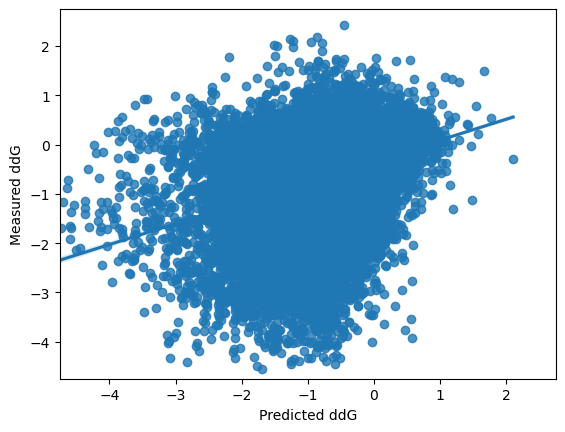

In [312]:
preds =[]
all_y = []

for batch in dataloader_val:
    # read from batch
    x = batch["sequence"][0]
    mask = batch["mask"][0]
    target = batch["labels"][0]
    ## adjust to work with your model
    # predict
    prediction = cnn_model(x)
    preds.append(prediction[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence
    all_y.append(target[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
plt.xlim(-4.75, 2.75)
plt.ylabel("Measured ddG")
plt.ylim(-4.75, 2.75)
# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared = False))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))

In [48]:
#not possible for non classification tasks

# Plot a ROC curve
from sklearn.metrics import roc_curve, auc

# get predictions (as probabilities)
def get_prediction_probs(dataloader_train, model):
    y_true = []
    y_pred = []

    for images, labels in dataloader_train:
        images = images#.to(device)
        labels = labels.numpy()
        outputs = model(images)
        # exp() because we use log softmax as last layer
        # get the probabilities for tomor class 
        prediction_probabilities = torch.exp(outputs)[:,1] 
        pred = prediction_probabilities.detach().cpu().numpy()
    
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred

y_true, y_pred_probabilities = get_prediction_probs(dataloader_train, cnn_model)

########## TODO #############
# compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true,y_pred_probabilities)
roc_auc = auc(fpr,tpr)
##############################

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color="grey")
plt.legend()

ValueError: too many values to unpack (expected 2)